In [1]:
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget
from pdfstream.cli import integrate
from pdfstream.transformation.cli import transform
import numpy as np
import os
import glob
from tifffile import imread, imsave
import pyFAI, pyFAI.azimuthalIntegrator
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import subprocess
from itertools import groupby
import shutil
import subprocess
print(os.getcwd())



C:\Users\hzhong\OneDrive - Brookhaven National Laboratory\Documents\Python Scripts\pdfstream


In [2]:
def globfilename(path, search_item='*.tiff'):
    filenames = glob.glob(path+search_item)
    if len(filenames) == 0:
        raise ValueError('No files found in the path!')
    inputnames=[filename.replace('\\','/') for filename in filenames]
    return(inputnames)

def count_header(filename):
    with open (filename,'r') as myfile:
        data = myfile.read().splitlines()
    count = 0
    for lines in data:
        if lines[0] == '#':
            count +=1
    return count

In [59]:
def copy_rename(path, given_name=None, search_item='*.tiff', attr = None, saveout='filename.txt', output_dir=None):   
    ''' 
    make a copy and rename all files under path, if not given a output_dir, will copy and rename files at the same directory
    filenames and it's renamed filename are saved in a txt file as a record
    path -- could be a path or list of filenames
    attr([start, end]) -- group files by given start position and end position of the string(the name you want to keep)
    
    '''
    if isinstance(path, list):
        filenames.sort()
        path = os.path.dirname(filenames[0])
        path = path + '/'
    else:    
        filenames = globfilename(path, search_item)
        filenames.sort()
    print(f'Total file found: {len(filenames)}')

    outputfilename=[]
    
    if output_dir is None:
        output_dir = path    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    seris=[]
    try:
        for fname in filenames:
            basename=os.path.splitext(os.path.basename(fname))[0]
            i = basename.split('-')[-1]
            seris.append(int(i))
        if np.sum(seris) == 0:
            is_seri = False
        else:
            is_seri = True
    except:
        is_seri = False

        
    if attr is None:  
        for i, fname in enumerate(filenames):
            basename=os.path.splitext(os.path.basename(fname))[0]
            ext=os.path.splitext(os.path.basename(fname))[-1]
            if is_seri:
                seri = basename.split('-')[-1].zfill(4)            
            else:
                seri = str(i).zfill(3)
            givename = given_name
            shutil.copy(fname, f'{output_dir}{givename}_{seri}{ext}')
            outputfilename.append(basename+'\t'+f'{givename}_{seri}{ext}'+'\n')
    else:
        path_len=len(path)
        s,e=attr
        grouped_names = [list(v) for l,v in groupby(sorted(filenames, key=lambda x:x[s:e+path_len]), lambda x: x[s:e+path_len])]  #the first 25 characters in the filenames
        for name in grouped_names:
            for i, fname in enumerate(name):
                basename=os.path.splitext(os.path.basename(fname))[0]
                ext=os.path.splitext(os.path.basename(fname))[-1]
                if is_seri:
                    seri = basename.split('-')[-1].zfill(4)            
                else:
                    seri = str(i).zfill(3)
                givename = basename[s:e]
                shutil.copy(fname, f'{output_dir}{givename}_{seri}{ext}')
                outputfilename.append(basename+'\t'+f'{givename}_{seri}{ext}'+'\n')
    saveout = output_dir + saveout    
    with open(saveout, 'a') as file_to_write_to:
        file_to_write_to.writelines(outputfilename) 

        
def copy_rename_temperature(sample_name, filepath, scalarpath, search_item='*.tiff', attr= None, output_dir=None,  viz = False):
    '''
    copy and rename .tiff as samplename_time_temperature.tiff to given subfolder (output_dir) or ./renamed_tiff
    temperature read from .csv files under scalepath
    '''
    
    if output_dir is None:
        output_dir='./renamed_tiff/'
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)        
    
    tiffnames=globfilename(filepath, search_item= search_item)
    
    seris=[]
    try:
        for fname in filenames:
            basename=os.path.splitext(os.path.basename(fname))[0]
            i = basename.split('-')[-1]
            seris.append(int(i))
        if np.sum(seris) == 0:
            is_seri = False
        else:
            is_seri = True
    except:
        is_seri = False
    
    if attr is None:
        for fname in tiffnames:

            basename=os.path.splitext(os.path.basename(fname))[0]
            ext=os.path.splitext(os.path.basename(fname))[-1]
            splitname=basename.split('-')
            attrname="-".join(splitname[0:-2])
            
            scalar_name=globfilename(scalarpath, search_item=attrname+'*.csv')
            scalar_filename=scalar_name[0]
            temp=pd.read_csv(scalar_filename)['temperature_setpoint'][0]

            timeID=len(sample_name)
            if is_seri:
                seri = basename.split('-')[-1]
                basename1=[basename[0:timeID+16], seri, str(round(temp))]
            else:
                basename1=[basename[0:timeID+16], str(round(temp))]
            renamed_filename=output_dir + '_'.join(basename1) + ext
            shutil.copy(fname,renamed_filename)

            if viz is True:
                if ext == '.tiff':
                    
                    fig = plt.figure(figsize=(5,5),dpi=400)
                    img = imread(renamed_filename)
                    plt.imshow(img, vmin = np.min(img), vmax = np.max(img))
                else:
                    fig = plt.figure(figsize=(8,4))
                    header=count_header(renamed_filename)
                    x, y = np.loadtxt(renamed_filename, skiprows=header,unpack=True)
                    plt.plot(x, y)
                    plt.title(f'{"_".join(basename1)}')
    else:
        s,e = attr
        for fname in tiffnames:
            basename=os.path.splitext(os.path.basename(fname))[0]
            ext=os.path.splitext(os.path.basename(fname))[-1]
            attrname = basename[s:e]
            scalar_name=globfilename(scalarpath, search_item=attrname+'*.csv')
            scalar_filename=scalar_name[0]
            
            temp=pd.read_csv(scalar_filename)['temperature_setpoint'][0]
            if is_seri:
                seri = basename.split('-')[-1]
                basename1=[attrname, seri, str(round(temp))]
            else:
                basename1=[attrname, str(round(temp))]
            renamed_filename=output_dir + '_'.join(basename1) + ext
            shutil.copy(fname,renamed_filename)

            if viz is True:
                if ext == '.tiff':
                    fig = plt.figure(figsize=(5,5),dpi=400)
                    img = imread(renamed_filename)
                    plt.imshow(img, vmin = np.min(img), vmax = np.max(img))
                else:
                    fig = plt.figure(figsize=(8,4))
                    header=count_header(renamed_filename)
                    x, y = np.loadtxt(renamed_filename, skiprows=header,unpack=True)
                    plt.plot(x, y)
                    plt.title(f'{"_".join(basename1)}')
                    

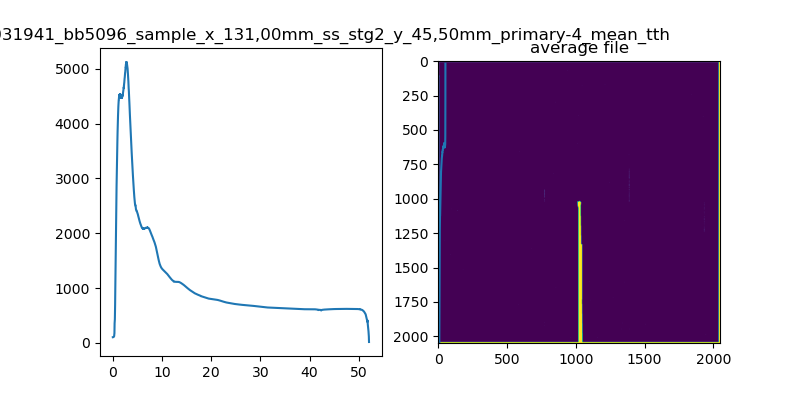

In [ ]:
path = './sample_1/'
mask1= globfilename(path, '*.npy')[0]
msk=np.load(mask1)
np.save(path+'test.npy', msk)
plt.imshow(msk, vmin=np.min(msk), vmax=np.max(msk))
plt.show()

In [57]:
path = './sample_1/integration/'
sum_bygroup(path, search_item='*_tth.chi', attr=[0, 25], output_dir = path+'avgchiT/')

Total file found: 90


In [56]:
sumpath = path+'sumchiT/'
scalarpath='./sample_1/scalar_data/'
sample_name ='Sample_1'
copy_rename_temperature(sample_name, sumpath, scalarpath, search_item='*.chi', attr= [0,25], output_dir=path+'sum_renameT/')

In [62]:
def sumfiles(path, search_item='*.tiff', sumrange=None, sample_name=None, output_dir=None, viz=False):    
    
    if isinstance(path, list):  #if path is a list of filenames
        filenames = path
        filenames.sort()
        path = os.path.dirname(filenames[0])
        path = path + '/'
    else:    
        filenames = globfilename(path, search_item)
        filenames.sort()

    sums=0
    if sumrange is not None:
        sumstart, sumend=sumrange
        filenames=filenames[sumstart:sumend]
        print(filenames)
    if output_dir is None:
        output_dir = path    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    
    if sample_name is None:
        basename=os.path.splitext(os.path.basename(filenames[0]))[0]
    else:
        basename=sample_name
    ext=os.path.splitext(os.path.basename(filenames[0]))[-1]
    outputfile = f'{output_dir}{basename}_sum{ext}'    
    
    if ext =='.tiff':
        for filename in filenames:
            img = imread(filename)
            sums = sums+img         
        imsave(outputfile, sums) 
        if viz is True:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            img = imread(filenames[0])
            axs[0].imshow(img, vmin = np.min(img), vmax = np.max(img))
            axs[0].set_title(f'{basename}')
            axs[1].imshow(sums, vmin = np.min(sums), vmax = np.max(sums))
            axs[1].set_title('sum file')
    elif ext =='.npy':
        for filename in filenames:
            img = np.load(filename)
            sums = sums+img         
        imsave(outputfile, sums) 
        if viz is True:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            img = imread(filenames[0])
            axs[0].imshow(img, vmin = np.min(img), vmax = np.max(img))
            axs[0].set_title(f'{basename}')
            axs[1].imshow(sums, vmin = np.min(sums), vmax = np.max(sums))
            axs[1].set_title('sum file')        
    elif ext in ('.chi', '.xy'):
        header=count_header(filenames[0])
        for filename in filenames:
            x,y= np.loadtxt(filename, skiprows=header,unpack=True)
            sums = sums+y         
        np.savetxt(outputfile, np.vstack((x,sums)).T)
        if viz is True:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            x, y = np.loadtxt(filenames[0], skiprows=header,unpack=True)
            axs[0].plot(x, y)
            axs[0].set_title(f'{basename}')
            axs[1].plot(x, sums)
            axs[1].set_title('sum file') 
    else:
        print(f'Not support extension {ext} file')
        return None
            
def avgfiles(path, search_item='*.tiff', avgrange=None, sample_name=None,output_dir=None,viz=False):    
    
    if isinstance(path, list):   #if path is a list of filemanes
        filenames = path
        filenames.sort()
        path = os.path.dirname(filenames[0])
        path = path + '/'
    else:    
        filenames = globfilename(path, search_item)
        filenames.sort()
           
    sums=0
    counts=0
    
    if avgrange is not None:
        avgstart, avgend=avgrange
        filenames=filenames[avgstart:avgend]
        print(filenames)
    if output_dir is None:
        output_dir = path    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
        
    if sample_name is None:
        basename=os.path.splitext(os.path.basename(filenames[0]))[0]  
    else:
        basename=sample_name
    ext=os.path.splitext(os.path.basename(filenames[0]))[-1]
    outputfile = f'{output_dir}{basename}_average{ext}'  

    if ext == '.tiff':
        for filename in filenames:
            img = imread(filename)
            sums = sums+img 
            counts+=1    
        avg=sums/counts    
        imsave(outputfile, avg)
        if viz is True:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            img = imread(filenames[0])
            axs[0].imshow(img, vmin = np.min(img), vmax = np.max(img))
            axs[0].set_title(f'{basename}')
            axs[1].imshow(avg, vmin = np.min(avg), vmax = np.max(avg))
            axs[1].set_title('average file')
    elif ext == '.npy':
        for filename in filenames:
            img = np.load(filename)
            sums = sums+img 
            counts+=1    
        avg=sums/counts    
        imsave(outputfile, avg)
        if viz is True:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            img = imread(filenames[0])
            axs[0].imshow(img, vmin = np.min(img), vmax = np.max(img))
            axs[0].set_title(f'{basename}')
            axs[1].imshow(avg, vmin = np.min(avg), vmax = np.max(avg))
            axs[1].set_title('average file')
    elif ext in ('.chi', '.xy'):
        header=count_header(filenames[0])
        for filename in filenames:
            x,y= np.loadtxt(filename, skiprows=header,unpack=True)
            sums = sums+y
            counts+=1
    
        avg=sums/counts 
        np.savetxt(outputfile, np.vstack((x,avg)).T)
        if viz is True:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            x, y = np.loadtxt(filenames[0], skiprows=header,unpack=True)
            axs[0].plot(x, y)
            axs[0].set_title(f'{basename}')
            axs[1].plot(x, avg)
            axs[1].set_title('average file')    
    else:
        print(f'Not support extension {ext} file')
        return None

In [16]:
def run_calib(calibfile, calibrant='Ni', wavelength=0.1847):
    det='Perkin'    
    subprocess.call(['pyfai-calib2',f'--wavelength={wavelength}',f'--detector={det}',f'--calibrant={calibrant}',calibfile])

def sum_bygroup(path, search_item='*.tiff', attr=[0, 25], output_dir = None, viz=False):
    '''
    sum all files under path, grouped by groupby, which is the range in filenames you set for searching in filenames
    example: attr=[0, 25] files has same characters in range [0:25] will be grouped as one group to process(sum and average)
    '''
    path_len=len(path)
    s,e=attr
    fnames = globfilename(path, search_item)
    print(f'Total file found: {len(fnames)}')

    grouped_names = [list(v) for l,v in groupby(sorted(fnames, key=lambda x:x[s:e+path_len]), lambda x: x[s:e+path_len])]  #the first 25 characters in the filenames
    for name in grouped_names:             
        sumfiles(name, output_dir = output_dir, viz = viz)

def avg_bygroup(path, search_item='*.tiff', attr=[0, 25], output_dir = None, viz=False):
    '''
    average all files under path, grouped by groupby, which is the range in filenames you set for searching in filenames
    example: attr=[0, 25] files has same characters in range [0:25] will be grouped as one group to process(sum and average)
    '''
    path_len=len(path)
    s,e=attr
    fnames = globfilename(path, search_item)
    print(f'Total file found: {len(fnames)}')
    grouped_names = [list(v) for l,v in groupby(sorted(fnames, key=lambda x:x[s:e+path_len]), lambda x: x[s:e+path_len])]  #the first 25 characters in the filenames
    for name in grouped_names:       
        avgfiles(name, output_dir = output_dir, viz = viz)

def overlay_plot(path, search_item='*.xy', headers=40):
    fnames = globfilename(path, search_item)
    print(f'Total file found: {len(fnames)}')
    for fname in fnames:
        x, y = np.loadtxt(fname, skiprows = headers, unpack = True)
        plt.plot(x, y)
        plt.show()

def background_sub(path, search_item='*.chi', bkgfile=None,  bkg_scale=1, headers=40, output_dir=None, viz=True):
    
    if isinstance(path, list):   #if path is a list of filemanes
        filenames = path
        filenames.sort()
        path = os.path.dirname(filenames[0])
        path = path + '/'
    else:    
        filenames = globfilename(path, search_item)
        filenames.sort()
    if headers is None:
        headers = count_header(filenames[0])
    if bkgfile is not None:
        bkgx, bkgy= np.loadtxt(bkgfile, skiprows=headers, unpack=True)
        
        
    if output_dir is None:
        output_dir = path    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
        
    ext=os.path.splitext(os.path.basename(filenames[0]))[-1]      
    
    for fname in filenames:
        x, y = np.loadtxt(fname, skiprows = headers, unpack = True)
        ysub=y-bkgy*bkg_scale

        if viz is True:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            axs[0].plot(x, y,'b')
            axs[0].plot(x, bkgy*bkg_scale,'r')            
            axs[0].set_title(f'overlay bkg')
            
            axs[1].plot(x, ysub)
            axs[1].set_title('bkg subtracted') 

        basename=os.path.splitext(os.path.basename(fname))[0] 
        outputfile = f'{output_dir}{basename}_bkg_sub{ext}' 
  
        np.savetxt(outputfile, np.vstack((x,ysub)).T)

In [14]:
def pdfstream_integrate(path, search_item='*.tiff', ponifile='*.poni', maskfile='*.npy', poni_path=None, output_dir=None, bkg_file=None, bkg_scale=1, img_setting="OFF", plot_setting="OFF", q_out=False):
    
    if isinstance(path, list): # if path is a list of filenames
        filenames=path
        path = os.path.dirname(filenames[0])
        path=path+'/'
    else:
        filenames = globfilename(path, search_item)
    
    if output_dir is None:
        output_dir = path

    if not os.path.exists(output_dir):
        os.mkdir(output_dir)    
    
    if poni_path is None:
        poni_path = path
        
    if ponifile == '*.poni':
        ponifile1 = globfilename(poni_path, search_item = ponifile)
        ponifile=ponifile1[0]
    else:
        ponifile=poni_path+ponifile
    if maskfile == '*.npy':
        maskfile1 = globfilename(poni_path, search_item = maskfile)
        maskfile = maskfile1[0]
    elif maskfile is None:
        maskfile = None
    else:
        maskfile=poni_path + maskfile
  
    for filename in filenames:
        
        integrate(ponifile,
             filename,
             integ_setting = {
                    "npt": 2048,
                    "unit": "2th_deg"                
                 },     
             mask_file = maskfile,
             mask_setting = 'OFF',
             bg_img_file = bkg_file,
             bg_scale = bkg_scale,
             img_setting = img_setting,
             plot_setting = plot_setting,
             output_dir = path + 'chi_tth_file')
        if q_out:
            integrate(ponifile,
                 filename,
                 mask_file = maskfile,
                 mask_setting= "OFF",
                 bg_img_file = bkg_file,
                 bg_scale = bkg_scale,
                 img_setting = img_setting,
                 plot_setting = plot_setting,
                 output_dir= path +'chi_q_file')

#create a configuration file
#subprocess.call(['pdfgetx3','--createconfig=pdfconfig.cfg'])
            
def pdfstream_transform(path, search_item='*.chi', config_file='pdfconfig.cfg', output_dir=None):
    '''
    #create a configuration file
    subprocess.call(['pdfgetx3','--createconfig=pdfconfig.cfg'])
    
    path could be a path (string) or a list of filenames(list)
    '''
    
    if isinstance(path, list):
        filenames=path
        path = os.path.dirname(filenames[0])
        path=path+'/'
    else:  
        filenames = globfilename(path, search_item)
    if output_dir is None:
        output_dir = path
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    for filename in filenames:
        transform(
        config_file, 
        filenames[0],
        output_dir=output_dir)



In [15]:
def insert_line(filename, headerline, outputfile):
    with open(filename, 'r') as f:
     #readlines in file and put in a list
        context = f.readlines()
    #insert /* at first line insert */ at headerline +1
    context.insert(0, "/*")
    context.insert(headerline+1, '*/'+'\n')
    with open(outputfile, 'w') as file_to_write_to:
        file_to_write_to.writelines(context) 

def tatreat(path, search_item='*.xy', attr=[0, 25], subfolder='ta', header=None, saveout='filenames.txt'):
    '''
    -- add /* and */ to the header. 
        if .xy file from diaptas, you do not need to put input for header
        other files, please put the numer of header.e.g.  header = 8
    --short filename, filename 
        only include the sample name and the timestamp  
        temp series, include sample name, timestamp and temp 
    --save files under new folder /ta/
    
    '''
    s, e = attr
    inputnames = globfilename(path, search_item=search_item)
    if header is None:
        header =count_header(inputnames[0])
    print(len(inputnames))
    destination_path = f'{path}{subfolder}'
    if not os.path.exists(destination_path):
        os.mkdir(destination_path)
    outputfilename=[]
    for filename in inputnames:
        fname=filename.split('/')[-1]
        basename=fname.split('.')[0]
        basename=basename[s:e]
        filename_out=f'{destination_path}/{basename}.xy'
        print(f'{basename}.xy')
        insert_line(filename, header, filename_out)
        outputfilename.append(filename_out)
    saveout=path + saveout    
    with open(saveout, 'a') as file_to_write_to:
        file_to_write_to.writelines(outputfilename)
    return 

In [45]:
path = './sample_1/dark_sub/'
sum_bygroup(path, search_item='*.tiff', attr=[0,25], output_dir =path+'sum_tiff/',viz=True)

In [46]:
pathsum = path +'sum_tiff/'
scalarpath='./sample_1/scalar_data/'

copy_rename_temperature('Sample_1', pathsum, scalarpath, attr=[0,25], output_dir = path+'temp_tiff/')

In [47]:
path ='./sample_1/dark_sub/'

copy_rename(pathsum,  attr=[0, 24], output_dir=path +'rname1/')

Total file found: 18


In [ ]:
path='./sample_1/chi_tth_file/'
avgfiles(path, search_item='*.chi', output_dir=path+'avg/', viz=True)

In [ ]:
path1='./sample_1/rname2/'
#avg_bygroup(path1, attr=[0, 25], output_dir=path1+'avg/', viz=True)

In [ ]:
path = './sample_1/'
pdfstream_integrate(path, '/rname2/*.tiff', maskfile=None)

Total file found: 4


<IPython.core.display.Javascript object>


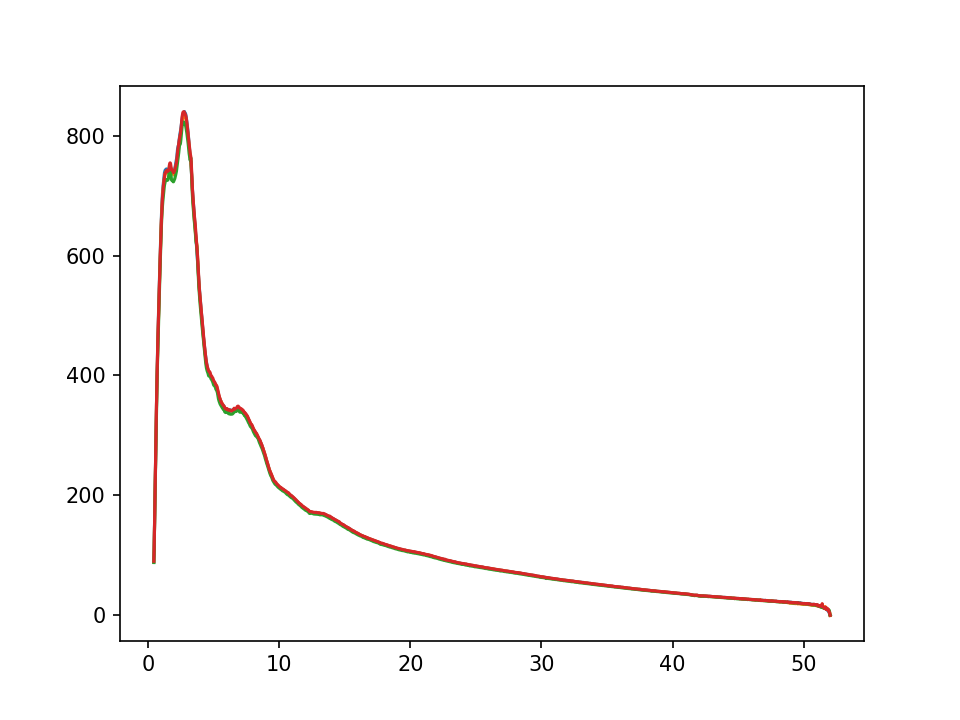

In [22]:
path = './sample_1/chi_tth_file/'
#tatreat(path, search_item='*.chi', attr=[0, 24])
overlay_plot(path, search_item='*.chi')

In [37]:
path = './sample_1/chi_tth_file/avg/'
#pdfstream_transform(path)

In [52]:

calib_path='./Test_Data_Chi/Ni_PDF/dark_sub/'
Ni_file=globfilename(calib_path)
run_calib(Ni_file[0], wavelength=0.18447)

In [5]:
path ='./Ni/'
filenames=globfilename(path, '*.tiff')
sumtiff(path)
avgtiff(path)

In [28]:
filename=globfilename(path,'*.tiff')
fname=filename[0]
fname

'./Ni/Ni_20220201-185134.tiff'

In [29]:
run_calib(fname, wavelength=0.1857)

In [17]:
filenames=globfilename(path,'*.tiff')
len(filenames)

4

In [20]:
#poni file and maskfile are saved at the same path with filenames,
#and one one .poni file and .npy file, do not have to give the poni and npy file
#pdfstream_integrate(filenames[0])

In [21]:
#pdfstream_integrate_batch(path)

In [12]:
#create a configuration file
subprocess.call(['pdfgetx3','--createconfig=pdfconfig.cfg'])

1

In [24]:
chifile_path=path+'chi_tth_file/'
filenames = globfilename(chifile_path, '*.chi')
print(len(filenames))
filenames[0]

6


'./Ni/chi_tth_file/Ni_20220201-185134.chi'

In [26]:
tatreat(chifile_path, '*.chi')

Ni_20220201-185134.xy
Ni_20220201-185134.xy
Ni_20220201-185134.xy
Ni_20220201-185134_average.xy
Ni_20220201-185134_sum.xy
Ni_20220201-205430.xy


In [75]:
#pdfstream_transform(filenames, output_dir='data_file')